# Class 2 - Classifiers evaluation

### Import needed modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
plt.style.use('seaborn-white') #changing plot style
plt.rcParams['figure.dpi']=90.0 #size of figures

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## 1. Splitting dataset into train and validation subsets

**Data loading & pre-processing**

In [4]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric"
DATA_SET = pd.read_fwf(url, header = None)
DATA_SET.rename(columns = {24: "target"}, inplace=True)
DATA_SET['target'] = DATA_SET['target'] - 1 #recoding target variable
DATA_SET

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,target
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,0
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,0
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,0
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,1


In [5]:
X = DATA_SET.drop(['target'], axis=1)
y = DATA_SET['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [6]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(700, 24) (300, 24)
(700,) (300,)


Is random sampling the best approach? What if one class has many more records than the other?
Imbalanced data may lead to poor model which may have good overall performance metrics e.g. accuracy.

There are several approaches to tackle the issue:
- undersampling, 
- oversampling, 
- cost-based performance,
- algorithmic approches e.g.SMOTE

Quick reading with code samples:
[Article on imbalanced data in Python](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

**Cost-based approach in model assessment**

In [7]:
def cutoff_analysis(y_test: pd.Series, y_test_hat: pd.Series, cost_matrix: np.array = np.array([[0,0],[0,0]]) ) -> list:
    """
    Calculate accuracy vector for cutoff thresholds between 0 and 1 for given true labels `y_test` 
    and predicted labels `y_test_hat`. If `cost_matrix` is specified, calculates cost vector instead.
    """
    cutoff_range = np.arange(0, 1.0, 0.01)
    vec = []
    for cutoff in cutoff_range:
        y_test_hat_bin = np.where(y_test_hat >= cutoff, 1, 0)
        conf_mat = confusion_matrix(y_test, y_test_hat_bin)
        #no cost matrix, calculate accuracy
        if np.sum(cost_matrix) == 0:
            vec.append(np.sum(np.diag(conf_mat)) / np.sum(conf_mat))
        else:
            conf_const_mat = np.multiply(conf_mat, cost_matrix)
            vec.append(conf_const_mat.sum() / len(y_test))
    return vec

**Building logistic regression model**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png" align="left">

https://en.wikipedia.org/wiki/Logistic_regression

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [8]:
model = LogisticRegression(max_iter=10000)
LR_L1 = model.fit(X_train,y_train)

In [9]:
LR_L1.coef_

array([[-0.50024181,  0.03656489, -0.52737227,  0.00574313, -0.22709638,
        -0.13580359, -0.23705178,  0.08353879,  0.16111406, -0.01736681,
        -0.25011347,  0.38995893,  0.08657607, -0.34294273, -0.74295136,
         0.65933666, -0.99339983,  0.64537887,  1.02412351,  0.32383257,
        -0.08241675, -0.66654138,  0.07709692, -0.1152778 ]])

**Measuring model performance (cost-based) for different cutoof thresholds and with or without validation dataset**

In [10]:
#On validation data
score_val = LR_L1.predict_proba(X_test)[:,1]
#On training data
score_train = LR_L1.predict_proba(X_train)[:,1]

In [11]:
costmat = np.array([[0,1],[5,0]])
cost_val = cutoff_analysis(y_test, score_val, cost_matrix = costmat)
cost_train = cutoff_analysis(y_train, score_train, cost_matrix = costmat)
costmat

array([[0, 1],
       [5, 0]])

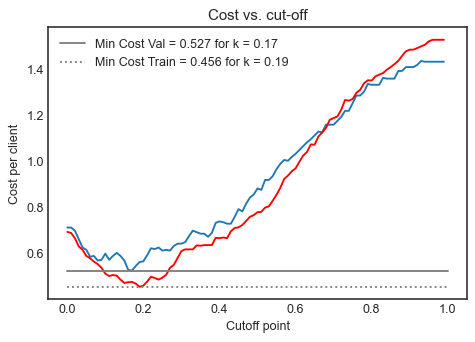

In [12]:
plt.figure()
plt.xlabel("Cutoff point")
plt.ylabel("Cost per client")
plt.title("Cost vs. cut-off")

plt.plot(np.arange(0, 1.0, 0.01), cost_val)
plt.plot(np.arange(0, 1.0, 0.01), cost_train, color = "red")
plt.plot([0, 1], [min(cost_val), min(cost_val)], color = 'gray', label = "Min Cost Val = " + \
         str(round(min(cost_val),3)) + " for k = " + str(round(np.arange(0, 1.0, 0.01)[cost_val.index(min(cost_val))],2)))
plt.plot([0, 1], [min(cost_train), min(cost_train)], color = 'gray', linestyle = ":", label = "Min Cost Train = " + \
         str(round(min(cost_train),3)) + " for k = " + str(np.arange(0, 1.0, 0.01)[cost_train.index(min(cost_train))]))

plt.legend();

Looks like we got lower cost for predictions on training set, but model may **overfit**.


## 2. Assessing model performance

In [13]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
dataset = pd.read_csv(url, sep = " ", header = None)
dataset.columns = ["V" + str(i) for i in range(0,15)]
dataset.rename(columns = {"V14": "class"}, inplace = True)

dataset['V3'] = np.where(dataset['V3'] == 1, 0, 1)
dataset['V11'] = np.where(dataset['V11'] == 1, 0, 1)
dataset['V13'] = np.log(dataset['V13'])
dataset

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,class
0,1,22.08,11.460,1,4,4,1.585,0,0,0,1,1,100,7.100852,0
1,0,22.67,7.000,1,8,4,0.165,0,0,0,0,1,160,0.000000,0
2,0,29.58,1.750,0,4,4,1.250,0,0,0,1,1,280,0.000000,0
3,0,21.67,11.500,0,5,3,0.000,1,1,11,1,1,0,0.000000,1
4,1,20.17,8.170,1,6,4,1.960,1,1,14,0,1,60,5.068904,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,31.57,10.500,1,14,4,6.500,1,0,0,0,1,0,0.000000,1
686,1,20.67,0.415,1,8,4,0.125,0,0,0,0,1,0,3.806662,0
687,0,18.83,9.540,1,6,4,0.085,1,0,0,0,1,100,0.000000,1
688,0,27.42,14.500,1,14,8,3.085,1,1,1,0,1,120,2.484907,1


**Data split using sklearn**

In [14]:
training_fraction = 0.8
X = dataset.iloc[:, 0:14]
y = dataset.iloc[:, 14]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-training_fraction, random_state = 42)

**Logistic Regression estimation with L1 regularization**

In [15]:
model_log_reg = LogisticRegression(random_state = 42, solver = 'liblinear', penalty = 'l1')
model_log_reg_fit = model_log_reg.fit(X_train,y_train)

**L1 regularization allows for feature selection**

https://en.wikipedia.org/wiki/Lasso_(statistics)

Lasso = L1 on linear regression
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6f7b5020a85afe0ca7e4ac1bcda7d193bc812617)

In [16]:
model_log_reg_fit.coef_
#First coefficient is 0

array([[ 0.00000000e+00, -1.69462721e-02,  2.67751516e-03,
         7.34979539e-01,  2.09638469e-01, -3.32111031e-02,
         6.70704904e-02,  3.37556531e+00,  1.24064299e-02,
         1.72077009e-01, -2.82741877e-01, -5.59812282e-01,
        -1.95258002e-03,  1.55889403e-01]])

In [17]:
y_test_hat = model_log_reg.predict(X_test)

**Confusion matrix**

❗ Remember class indicator (0, 1,...) and actual or predicted values may be switched in confusion matrix

<img src="https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png" width=400>

<img src="https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg"  width=400>

**Performance measures derived from confusion matrix:**

- Accuracy - percentage of correct predictions

`ACC = (TP + TN)/(TP + FP + TN + FN)`

- Precision - percentage of positive predictions which were actually correct

`PREC = TP / (TP + FP)`

-  Recall - what percentage of actual positives were predicted correctly
 (Recall = Sensitivity = Hit rate = True Positive Rate (TPR))
 
`REC = TP / (TP + FN)`

- Specificity - what percentage of actual negatives were predicted correctly (Specificity = True Negative Rate)

`TNR = TN / (TN + FP)`

- F1 Score - traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/1bf179c30b00db201ce1895d88fe2915d58e6bfd)

In [18]:
confm = confusion_matrix(y_test, y_test_hat)
confm

array([[78,  9],
       [10, 41]], dtype=int64)

In [19]:
#What is what in that confusion matrix?
confusion_matrix?

In [20]:
ACC= (confm[0,0]+confm[1,1])/(confm[0,0]+confm[1,1]+confm[0,1]+confm[1,0])
PREC = (confm[1,1])/(confm[1,1]+confm[0,1])
REC = (confm[1,1])/(confm[1,1]+confm[1,0])
TNR = (confm[0,0])/(confm[0,0]+confm[0,1])
F1 = 2*PREC*REC/(PREC+REC)
print("ACC ",ACC,"\nPREC ",PREC,"\nREC ",REC,"\nTNR ",TNR,"\nF1 ",F1)

ACC  0.8623188405797102 
PREC  0.82 
REC  0.803921568627451 
TNR  0.896551724137931 
F1  0.8118811881188118


In [21]:
#Sklearn built-in report
print(classification_report(y_test,y_test_hat))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89        87
           1       0.82      0.80      0.81        51

    accuracy                           0.86       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.86      0.86      0.86       138



**Finding optimal cut-off based on ACC**

In [22]:
y_test_hat = model_log_reg.predict_proba(X_test)[:,1]
y_train_hat = model_log_reg.predict_proba(X_train)[:,1]
acc_k = cutoff_analysis(y_test, y_test_hat)

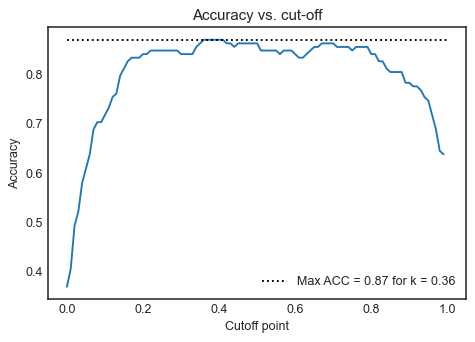

In [23]:
plt.figure()
plt.xlabel("Cutoff point")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. cut-off")

plt.plot(np.arange(0, 1.0, 0.01), acc_k)
plt.plot([0, 1], [max(acc_k), max(acc_k)], color = 'black', linestyle = ":", label = "Max ACC = " + \
         str(round(max(acc_k),3)) + " for k = " + str(np.arange(0, 1.0, 0.01)[acc_k.index(max(acc_k))]))
plt.legend();

### Visual analysis of a model

**Gain&Lift&ROC curves**

In [24]:
def gain_lift_roc_plot(y_test: pd.Series, y_test_hat: pd.Series, return_chart: str, n: int):
    """
    Produces Gain, Lift or ROC curve based on provided `y_test` true labels and `y_test_hat` prediction labels. 
    Wizard and Random models are added for comparison.
    """
    cutoff_range = np.arange(0, 1.0, 0.01)
    rpp = [0]*len(cutoff_range)
    tpr = rpp.copy()
    lift = rpp.copy()
    fpr = rpp.copy()
    prc = rpp.copy()
    x0 = np.mean(y_test)
    plt.subplot(2, 2, n)
    for i, cutoff in enumerate(cutoff_range):
        y_test_hat_bin = np.where(y_test_hat >= cutoff, 1, 0)
        conf_mat = confusion_matrix(y_test, y_test_hat_bin)
        rpp[i] = np.sum(conf_mat[:,1]) / np.sum(conf_mat)
        fpr[i] = conf_mat[0,1] / np.sum(conf_mat[0,:])
        tpr[i] = conf_mat[1,1] / np.sum(conf_mat[1,:])
        prc[i] = conf_mat[1,1] / np.sum(conf_mat[:,1])
        lift[i] = tpr[i] / rpp[i]
    for i, cutoff in enumerate(cutoff_range):
        y_test_hat_bin = np.where(y_test_hat >= cutoff, 1, 0)
        conf_mat = confusion_matrix(y_test, y_test_hat_bin)
        rpp[i] = np.sum(conf_mat[:,1]) / np.sum(conf_mat)
        fpr[i] = conf_mat[0,1] / np.sum(conf_mat[0,:])
        tpr[i] = conf_mat[1,1] / np.sum(conf_mat[1,:])
        prc[i] = conf_mat[1,1] / np.sum(conf_mat[:,1])
        lift[i] = tpr[i] / rpp[i]
    if return_chart == "gain":
        plt.xlabel("Rate of Positive Predictions")
        plt.ylabel("True Positive Rate")
        plt.plot(rpp, tpr, color="orange", label = "Model")
        plt.plot([0,1],[0,1], color='grey', linestyle="--", label = "Random") # random
        plt.plot([0,x0],[0,1], color='navy', linestyle=':', label = "Wizard") # wizard
        plt.plot([x0,1],[1,1], color='navy', linestyle=':') # wizard
        plt.legend(loc = "lower right")
        plt.title("Gain chart")
    elif return_chart == "lift":
        plt.xlabel("Rate of Positive Predictions")
        plt.ylabel("Lift")
        plt.plot(rpp, lift, color="orange", label = "Model")
        plt.plot([0,1],[1,1], color='grey', linestyle="--", label = "Random") # random
        plt.plot([0,x0],[1/x0,1/x0], color='navy', linestyle=':', label = "Wizard") # wizard
        #plt.plot([x0,1],[1/x0,1], color='navy', linestyle=':') # wizard
        plt.plot(np.arange(x0, 1, 0.01), 1/np.arange(x0, 1, 0.01), color='navy', linestyle=':') # wizard
        plt.legend(loc = "upper right")
        plt.title("Lift chart")
    elif return_chart == "roc":
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.plot(fpr, tpr, color="orange", label = "Model")
        plt.plot([0,1],[0,1], color='grey', linestyle="--", label = "Random") # random
        plt.plot([0,0],[0,1], color='navy', linestyle=':', label = "Wizard") # wizard
        plt.plot([0,1],[1,1], color='navy', linestyle=':') # wizard
        plt.legend(loc = "lower right")
        plt.title("ROC chart")
    plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)

In [25]:
np.mean(y_test)

0.3695652173913043

In [26]:
1/np.mean(y_test)

2.7058823529411766

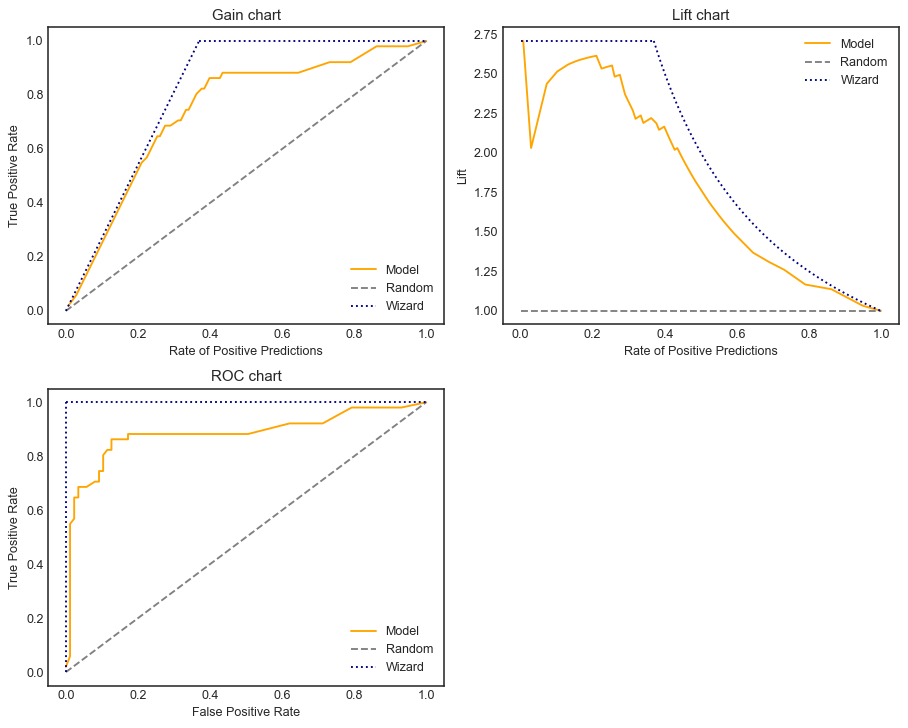

In [27]:
plt.rcParams['figure.figsize'] = [10, 8]
gain_lift_roc_plot(y_test, y_test_hat,"gain",1)
gain_lift_roc_plot(y_test, y_test_hat,"lift",2)
gain_lift_roc_plot(y_test, y_test_hat, "roc",3)

**ROC curve + AUC**

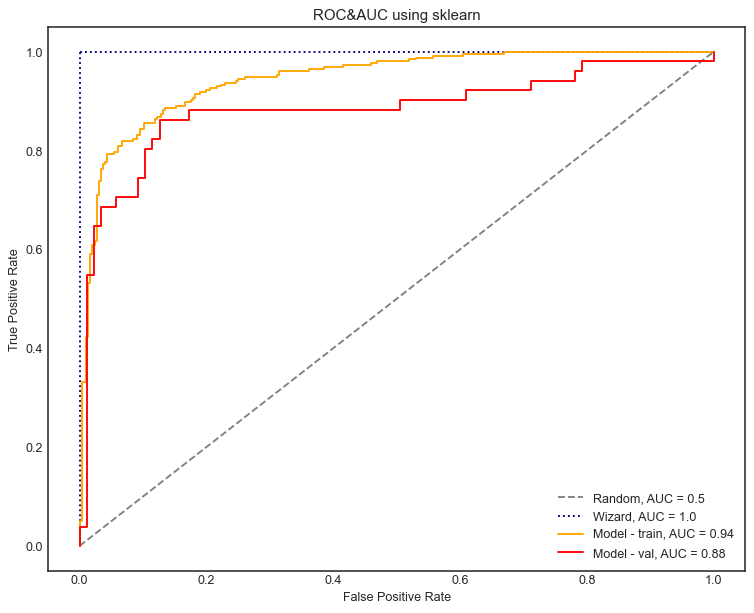

In [28]:
fprv, tprv, _ = roc_curve(y_test, y_test_hat)
fprt, tprt, _ = roc_curve(y_train, y_train_hat)
auc_rocv = auc(fprv, tprv)
auc_roct = auc(fprt, tprt)

plt.figure()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC&AUC using sklearn")

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label = "Random, AUC = 0.5")
plt.plot([0, 0], [0, 1], color='navy', linestyle=':', label = "Wizard, AUC = 1.0")
plt.plot([0, 1], [1, 1], color='navy', linestyle=':')

plt.plot(fprt, tprt, color = 'orange', label='Model - train, AUC = %0.2f' % auc_roct)
plt.plot(fprv, tprv, color = 'red', label='Model - val, AUC = %0.2f' % auc_rocv)
plt.legend(loc="lower right");

**Score-density plot**

In [ ]:
def score_density_plot(y_test: pd.Series, y_test_hat: pd.Series):
    basis_x = np.linspace(-0.2,1.2,1000)
    y_test_hat_0 = np.array(y_test_hat[y_test == 0])
    y_test_hat_1 = np.array(y_test_hat[y_test == 1])
    wizard_0 = np.array(y_test[y_test == 0])
    wizard_1 = np.array(y_test[y_test == 1])
    avg = np.mean(y_test)
    ran = [1]
    for i in range(0,len(y_test)-1):
        ran = ran + [int(np.mean(ran) < avg)]
    ran = np.array(ran)
    random_0 = np.linspace(0,1.0,len(y_test))[ran==0]
    random_1 = np.linspace(0,1.0,len(y_test))[ran==1]
    res = []
    for m in [y_test_hat_0, y_test_hat_1, wizard_0, wizard_1, random_0, random_1]:
        kde = KernelDensity(kernel='epanechnikov', bandwidth=0.20)
        kde.fit(m[:, None])
        prob = np.exp(kde.score_samples(basis_x[:, None]))
        res.append(prob)
        
    plt.figure()
    plt.plot(basis_x, res[0], alpha=0.5, color = "orange", lw=2, label = "Model")
    plt.plot(basis_x, res[1], alpha=0.5, color = "orange", linestyle=":", lw=2)
    plt.plot(basis_x, res[2], alpha=0.5, color = "navy", label = "Wizard")
    plt.plot(basis_x, res[3], alpha=0.5, color = "navy", linestyle=":")
    plt.plot(basis_x, res[4], alpha=0.5, color = "grey", label = "Random")
    plt.plot(basis_x, res[5], alpha=0.5, color = "grey", linestyle=":")
    plt.title("Score density plot")
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.legend(loc = "upper center")

In [ ]:
a = score_density_plot(y_test, y_test_hat)

## Exercises

Load Iris dataset from https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv to 'iris' DataFrame

Code `species` column to have value 1 if iris is from _versicolor_ species and 0 otherwise

Split dataset to train and validation subsets using `train_test_split` function. Training set should have **75%** of all observations.

Build logistic regression (with `LogisticRegression` from `sklearn`) using **Elastic-net** regularization with 0.35 L1 ratio (only one solver supports that, check [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression))

You can read more about **Elastic-net** [here](https://en.wikipedia.org/wiki/Elastic_net_regularization)

Make classification report with `classification_report`. What is accuracy of the model?

Why accuracy is so low? If you want to know check [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Unsupervised-learning-example:-Iris-dimensionality) below `In[19]`. Plot shows how target classes are distributed in 2D space (which was possible due to dimensionality reduction technique PCA - note that we have 4 predictors (sepal_length/width,petal_length/width) not 2). Remember we merged setosa and virginica species - knowing that look were versicolor is on the plot.

Write function 

`plot_acc_train_vs_val(y_train, y_test, y_train_hat, y_test_hat)` 

that takes following arguments:

- y_train - array of class labels (0 or 1) for training data
- y_test - array of class labels (0 or 1) for validation data 
- y_train_hat - array of probabilities (0 to 1) for class 1 for training data
- y_test_hat - array of probabilities (0 to 1) for class 1 for validation data

and produce plot like in **Finding optimal cut-off based on ACC** subsection but for both prediction on training and validation data. 

While creating function you _can_ use code as below:

```python
    acc_t = cutoff_analysis(y_train, y_train_hat)
    acc_v = ...
    plt.figure()
    plt.xlabel("Cutoff point")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. cut-off")

    plt.plot(np.arange(0, 1.0, 0.01), acc_t)
    plt.plot(... , linestyle = ":")
    plt.plot([0, 1], [max(acc_t), max(acc_t)], color = 'gray', label = "Max ACC train= " + str(round(max(acc_t),3)) + 
             " for k = " + str(np.arange(0, 1.0, 0.01)[acc_t.index(max(acc_t))]))
    plt.plot(.....................................)
    plt.legend();
```

Then test your new function using (of course after filling placeholders):

```python
y_train_hat = model. ...
y_test_hat = model. ...
plot_acc_train_vs_val(y_train, y_test, y_train_hat, y_test_hat)
```

On the plot you may see that accuracy for train and validation sets prediction id quite similar. Shouldn't the accuracy be better on the training set prediction? In this case not necessarily becuase model is **underfitted** - in other words it's biased and may perform better on validation set.